Compare the effect of adding a sparsity network to a DietDNN with tuned LR, cosine annealing, and minmax scaling NMF.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '/home/am2770/Github/cancer-low-data')
sys.path.insert(0, '/home/am2770/Github/cancer-low-data/src')
sys.path.insert(0, '/home/am2770/Github/cancer-low-data/notebooks')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wandb
import datetime
from utils import *

In [4]:
datetime.datetime.now(datetime.timezone.utc).isoformat()

'2022-08-15T18:10:02.621077+00:00'

In [5]:
api = wandb.Api(timeout=60)

# DietDNN vs WPS

In [7]:
#### Get runs by tag
runs = api.runs('andreimargeloiu/low-data', {
	'$or': [
		{
			"tags": '45a6ac77'  # no sparsity network
		},
		{
			"tags": '3c8124bb', # with sparsity network
		 	'config.sparsity_regularizer_hyperparam': 0
		}
	],
	'State': 'finished',
})
print(len(runs))
runs = filter_runs(runs, return_dataframe=False)
print(f"Found {len(runs)} runs")
runs_df = transforms_runs_into_dataframe(runs)
print(runs_df.shape)

671
Found 669 runs
(669, 146)


In [8]:
runs_df['sparsity_type'].fillna('-', inplace=True)

In [9]:
### Plot
pd.options.display.float_format = '{:,.2f}'.format

grouped = runs_df[runs_df['model']=='dietdnn'].groupby(['dataset', 'model', 'sparsity_type'])
# g1 = grouped.agg({'bestmodel_train/balanced_accuracy': ['mean', 'std']})*100
# g1 = grouped.agg({'bestmodel_valid/balanced_accuracy': ['mean']})
# g2 = grouped.agg({'bestmodel_test/cross_entropy_loss': ['mean']})
g3 = grouped.agg({'bestmodel_test/balanced_accuracy': ['mean', 'std']})*100
g4 = grouped.size()

res = pd.concat([g3, g4], axis=1).round(decimals=2)
res

(bestmodel_test/balanced_accuracy, mean)  \
dataset               model   sparsity_type                                             
cll                   dietdnn -                                                 75.65   
                              global                                            76.05   
lung                  dietdnn -                                                 94.32   
                              global                                            94.65   
metabric-dr__200      dietdnn -                                                 57.28   
                              global                                            59.05   
metabric-pam50__200   dietdnn -                                                 93.67   
                              global                                            95.50   
prostate              dietdnn -                                                 86.96   
                              global                                            89.00   
smk                   dietdnn -                                                 63.40   
                              global                                            66.08   
tcga-2ysurvival__200  dietdnn -                                                 56.34   
                              global                                            56.52   
tcga-tumor-grade__200 dietdnn -                                                 54.44   
                              global                                            55.29   
toxicity              dietdnn -                                                 83.99   
                              global                                            88.01   

                                             (bestmodel_test/balanced_accuracy, std)  \
dataset               model   sparsity_type                                            
cll                   dietdnn -                                                 9.17   
                              global                                            7.26   
lung                  dietdnn -                                                 5.34   
                              global                                            4.83   
metabric-dr__200      dietdnn -                                                 6.62   
                              global                                            8.62   
metabric-pam50__200   dietdnn -                                                 6.43   
                              global                                            4.80   
prostate              dietdnn -                                                 6.73   
                              global                                            7.62   
smk                   dietdnn -                                                 8.19   
                              global                                            6.09   
tcga-2ysurvival__200  dietdnn -                                                 9.54   
                              global                                            6.24   
tcga-tumor-grade__200 dietdnn -                                                10.48   
                              global                                           11.29   
toxicity              dietdnn -                                                 7.01   
                              global                                            6.31   

                                              0  
dataset               model   sparsity_type      
cll                   dietdnn -              25  
                              global         25  
lung                  dietdnn -              25  
                              global         24  
metabric-dr__200      dietdnn -              25  
                              global         25  
metabric-pam50__200   dietdnn -              25  
                              global         24  
pro

In [ ]:
file_name = 'influence_sparsity_network'
res.to_csv(f'/home/am2770/Github/cancer-low-data/compute_results/csv/{file_name}.csv')
res.to_excel(f'/home/am2770/Github/cancer-low-data/compute_results/csv/{file_name}.xlsx')

In [10]:
temp = res.reset_index()
print(f"Without SPN: {temp[temp['sparsity_type']=='-'][('bestmodel_test/balanced_accuracy', 'mean')].mean()}")
print(f"With SPN: {temp[temp['sparsity_type']=='global'][('bestmodel_test/balanced_accuracy', 'mean')].mean()}")

Without SPN: 74.00555555555555
With SPN: 75.57222222222222


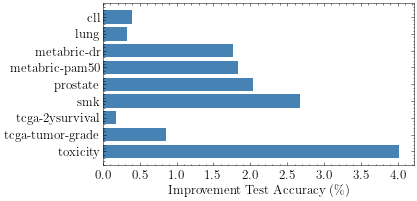

In [12]:
import seaborn as sns
import tikzplotlib

plt.style.use('science')

plt.figure(figsize=(6,3))
aux = res.reset_index()
aux.replace('metabric-dr__200', 'metabric-dr', inplace=True)
aux.replace('metabric-pam50__200', 'metabric-pam50', inplace=True)
aux.replace('tcga-tumor-grade__200', 'tcga-tumor-grade', inplace=True)
aux.replace('tcga-2ysurvival__200', 'tcga-2ysurvival', inplace=True)


datasets = aux[aux['sparsity_type']=='-'].dataset.astype('category')
y_pos = np.arange(len(datasets))
dietdnn_performance = aux[aux['sparsity_type']=='-'][('bestmodel_test/balanced_accuracy', 'mean')]
wps_performance = aux[aux['sparsity_type']=='global'][('bestmodel_test/balanced_accuracy', 'mean')]


plt.barh(y_pos, wps_performance.to_numpy() - dietdnn_performance.to_numpy(),
		 align='center', alpha=1, color='#4682B4')
# plt.barh(y_pos, dietdnn_performance, align='center', alpha=1, color='#d1d1d1', label='Without SPN')
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True, fontsize=14)

plt.xticks(fontsize=13)
plt.xlabel('Improvement Test Accuracy (\%)', fontsize=13)
plt.yticks(y_pos, labels=datasets, fontsize=13)
# plt.xlim(40, 100)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('figures/ablation_spn.pdf', dpi=200)